In [13]:
"""
CUDA-accelerated Conjugate Gradient (CG) with Jacobi preconditioning in Python
-----------------------------------------------------------------------------
Port of the logic from your `two.cxx` (CSR + CG + Jacobi) to **Python + CUDA**
using **CuPy** (wraps cuSPARSE/cuBLAS). Runs entirely on the GPU.

Features
- Builds the 2D Poisson/Laplacian 5-point stencil in **CSR** on GPU
- Right-hand-side f(x,y) sampling on GPU
- **Jacobi preconditioner** via cupyx LinearOperator
- Uses **cupyx.scipy.sparse.linalg.cg** (GPU CG) or a custom GPU CG loop
- Precise timing + residual report; optional host verification (skippable)

Just edit the values below (N, tol, maxiter, dtype) directly in the code.
"""
from __future__ import annotations
import os, time, math

# ---------------------------------------------------------------
# User parameters (edit here)
# ---------------------------------------------------------------
N = 5000           # grid size (N x N)
tol = 1e-8        # convergence tolerance
maxiter = 2000    # maximum CG iterations
dtype = "float32" # choose: "float32" or "float64"
# ---------------------------------------------------------------

# Prefer CuPy (GPU); allow CPU fallback for environments without CUDA
use_cpu_fallback = bool(int(os.environ.get("CPU_FALLBACK", "0")))

try:
    import cupy as cp
    import cupyx as cpx
    import cupyx.scipy.sparse as cusparse
    import cupyx.scipy.sparse.linalg as cusplinalg
    xp = cp
    sp = cusparse
    linalg = cusplinalg
    gpu_available = True and not use_cpu_fallback
except Exception as e:
    import numpy as cp  # type: ignore
    import numpy as xp
    from scipy import sparse as sp
    from scipy.sparse.linalg import cg as scipy_cg
    linalg = None
    gpu_available = False
    print("[WARN] CuPy not available. Falling back to CPU (NumPy/SciPy).", e)


def build_laplacian_2d_csr(N: int, dtype=xp.float32):
    """Build 5-point Laplacian on unit square with Dirichlet BC (interior grid N x N).
    Returns A (CSR, shape (N*N, N*N)).
    """
    n = N * N
    # Grid indices
    i = xp.arange(N, dtype=xp.int32)
    j = xp.arange(N, dtype=xp.int32)
    I, J = xp.meshgrid(i, j, indexing='ij')
    K = I * N + J  # 2D indexing of nodes

    rows, cols, vals = [], [], []

    # center (diagonal)
    rows.append(K.ravel())
    cols.append(K.ravel())
    vals.append(xp.full(n, 4.0, dtype=dtype))

    # left neighbor (j-1)
    m = J > 0
    if bool(m.any()):
        rows.append(K[m])
        cols.append((I*N + (J-1))[m])
        vals.append(xp.full(int(m.sum()), -1.0, dtype=dtype))

    # right neighbor (j+1)
    m = J < (N-1)
    if bool(m.any()):
        rows.append(K[m])
        cols.append((I*N + (J+1))[m])
        vals.append(xp.full(int(m.sum()), -1.0, dtype=dtype))

    # down neighbor (i-1)
    m = I > 0
    if bool(m.any()):
        rows.append(K[m])
        cols.append(((I-1)*N + J)[m])
        vals.append(xp.full(int(m.sum()), -1.0, dtype=dtype))

    # up neighbor (i+1)
    m = I < (N-1)
    if bool(m.any()):
        rows.append(K[m])
        cols.append(((I+1)*N + J)[m])
        vals.append(xp.full(int(m.sum()), -1.0, dtype=dtype))

    row = xp.concatenate(rows).astype(xp.int32, copy=False)
    col = xp.concatenate(cols).astype(xp.int32, copy=False)
    data= xp.concatenate(vals).astype(dtype,       copy=False)

    A = sp.coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    if hasattr(A, 'has_canonical_format'):
        A.has_canonical_format = True
        A.sum_duplicates()
    return A

    rows, cols, vals = [], [], []
    rows.append(k); cols.append(k); vals.append(diag)
    mask = J > 0;      rows.append(k[mask]); cols.append((I*N + (J-1))[mask]); vals.append(off[mask.ravel()])
    mask = J < (N-1);  rows.append(k[mask]); cols.append((I*N + (J+1))[mask]); vals.append(off[mask.ravel()])
    mask = I > 0;      rows.append(k[mask]); cols.append(((I-1)*N + J)[mask]); vals.append(off[mask.ravel()])
    mask = I < (N-1);  rows.append(k[mask]); cols.append(((I+1)*N + J)[mask]); vals.append(off[mask.ravel()])

    row = xp.concatenate(rows).astype(xp.int32, copy=False)
    col = xp.concatenate(cols).astype(xp.int32, copy=False)
    data= xp.concatenate(vals).astype(dtype,       copy=False)

    A = sp.coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    if hasattr(A, 'has_canonical_format'): A.has_canonical_format = True
    return A


def build_rhs(N: int, dtype=xp.float32):
    h = 1.0 / (N + 1)
    i = xp.arange(N, dtype=dtype)
    j = xp.arange(N, dtype=dtype)
    I, J = xp.meshgrid(i, j, indexing='ij')
    x = (J + 1) * h; y = (I + 1) * h
    f = (2 * (xp.pi**2)) * xp.sin(xp.pi * x) * xp.sin(xp.pi * y)
    b = (h * h) * f
    return b.ravel().astype(dtype)


def jacobi_preconditioner(A_csr):
    diag = A_csr.diagonal()
    invd = 1.0 / xp.maximum(diag, xp.finfo(diag.dtype).tiny)
    n = A_csr.shape[0]
    def mv(v): return invd * v
    if gpu_available:
        return cpx.scipy.sparse.linalg.LinearOperator((n, n), matvec=mv, dtype=A_csr.dtype)
    else:
        from scipy.sparse.linalg import LinearOperator
        return LinearOperator((n, n), matvec=mv, dtype=A_csr.dtype)


def cg_gpu(A, b, tol=1e-8, maxiter=1000, M=None):
    if gpu_available and hasattr(linalg, 'cg'):
        x, info = linalg.cg(A, b, tol=tol, maxiter=maxiter, M=M)
        return x, info

    n = b.size
    x = xp.zeros_like(b)
    r = b - A @ x
    z = M @ r if M is not None else r
    p = z.copy()
    rz_old = float(xp.dot(r, z))
    norm0 = float(xp.linalg.norm(r))

    for it in range(1, maxiter+1):
        Ap = A @ p
        alpha = rz_old / float(xp.dot(p, Ap))
        x = x + alpha * p
        r = r - alpha * Ap
        res = float(xp.linalg.norm(r))
        if res <= tol * (norm0 if norm0>0 else 1.0):
            return x, 0
        z = M @ r if M is not None else r
        rz_new = float(xp.dot(r, z))
        beta = rz_new / rz_old
        p = z + beta * p
        rz_old = rz_new
    return x, 1


def run(N=1024, tol=1e-8, maxiter=2000, dtype="float32"):
    dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64

    t0 = time.perf_counter()
    A = build_laplacian_2d_csr(N, dtype=dtype)
    b = build_rhs(N, dtype=dtype)
    t1 = time.perf_counter()
    M = jacobi_preconditioner(A)

    if gpu_available:
        (A @ b)
        M @ b
        xp.cuda.Stream.null.synchronize()

    t2 = time.perf_counter()
    x, info = cg_gpu(A, b, tol=tol, maxiter=maxiter, M=M)
    if gpu_available:
        xp.cuda.Stream.null.synchronize()
    t3 = time.perf_counter()

    r = b - A @ x
    if gpu_available:
        xp.cuda.Stream.null.synchronize()
    res_norm = float(xp.linalg.norm(r))

    h = 1.0 / (N + 1)
    i = xp.arange(N, dtype=dtype)
    j = xp.arange(N, dtype=dtype)
    I, J = xp.meshgrid(i, j, indexing='ij')
    xg = (J + 1) * h; yg = (I + 1) * h
    u_exact = xp.sin(xp.pi * xg) * xp.sin(xp.pi * yg)
    err_L2 = float(xp.linalg.norm(x - u_exact.ravel()))

    print(f"Backend     : {'GPU (CuPy)' if gpu_available else 'CPU (NumPy/SciPy)'}")
    print(f"Grid        : {N} x {N}  (unknowns = {N*N:,})  dtype={dtype}")
    print(f"Assemble    : {t1 - t0:8.3f} s")
    print(f"Solve (CG)  : {t3 - t2:8.3f} s  | info={info} (0=converged)")
    print(f"Residual    : {res_norm:.3e}")
    print(f"Exact L2    : {err_L2:.3e}")

    return x

# Run directly using user-set parameters above
run(N=N, tol=tol, maxiter=maxiter, dtype=dtype)


OutOfMemoryError: Out of memory allocating 100,000,256 bytes (allocated so far: 7,009,822,208 bytes).

In [17]:
"""
CUDA-accelerated Conjugate Gradient (CG) with Jacobi preconditioning in Python
-----------------------------------------------------------------------------
Port of the logic from your `two.cxx` (CSR + CG + Jacobi) to **Python + CUDA**
using **CuPy** (wraps cuSPARSE/cuBLAS). Runs entirely on the GPU.

Features
- Builds the 2D Poisson/Laplacian 5-point stencil in **CSR** on GPU
- Right-hand-side f(x,y) sampling on GPU
- **Jacobi preconditioner** via cupyx LinearOperator
- Uses **cupyx.scipy.sparse.linalg.cg** (GPU CG) or a custom GPU CG loop
- Precise timing + residual report; optional host verification (skippable)

Just edit the values below (N, tol, maxiter, dtype) directly in the code.
"""
from __future__ import annotations
import os, time, math

# ---------------------------------------------------------------
# User parameters (edit here)
# ---------------------------------------------------------------
N = 5000         # grid size (N x N)
tol = 1e-8       # convergence tolerance
maxiter = 2000   # maximum CG iterations
dtype = "float32"  # choose: "float32" or "float64"
MATRIX_FREE = True  # True avoids building/storing the big sparse matrix (no OOM)
# ---------------------------------------------------------------
N = 5000           # grid size (N x N)
tol = 1e-8        # convergence tolerance
maxiter = 2000    # maximum CG iterations
dtype = "float32" # choose: "float32" or "float64"
# ---------------------------------------------------------------

# Prefer CuPy (GPU); allow CPU fallback for environments without CUDA
use_cpu_fallback = bool(int(os.environ.get("CPU_FALLBACK", "0")))

try:
    import cupy as cp
    import cupyx as cpx
    import cupyx.scipy.sparse as cusparse
    import cupyx.scipy.sparse.linalg as cusplinalg
    xp = cp
    sp = cusparse
    linalg = cusplinalg
    gpu_available = True and not use_cpu_fallback
except Exception as e:
    import numpy as cp  # type: ignore
    import numpy as xp
    from scipy import sparse as sp
    from scipy.sparse.linalg import cg as scipy_cg
    linalg = None
    gpu_available = False
    print("[WARN] CuPy not available. Falling back to CPU (NumPy/SciPy).", e)


def build_laplacian_2d_csr(N: int, dtype=xp.float32):
    """Build 5-point Laplacian (Dirichlet) as CSR via Kronecker sums to reduce peak memory.
    A = kron(I, T) + kron(T, I), where T = tridiag([-1, 4, -1]).
    """
    n = N * N
    main = xp.full(N, 4.0, dtype=dtype)
    off  = xp.full(N-1, -1.0, dtype=dtype)
    T = sp.diags([off, main, off], offsets=[-1, 0, 1], shape=(N, N), dtype=dtype)
    I = sp.identity(N, dtype=dtype, format='csr')
    A = sp.kron(I, T, format='csr') + sp.kron(T, I, format='csr')
    if hasattr(A, 'has_canonical_format'):
        A.has_canonical_format = True
        A.sum_duplicates()
    return A

    rows, cols, vals = [], [], []
    rows.append(k); cols.append(k); vals.append(diag)
    mask = J > 0;      rows.append(k[mask]); cols.append((I*N + (J-1))[mask]); vals.append(off[mask.ravel()])
    mask = J < (N-1);  rows.append(k[mask]); cols.append((I*N + (J+1))[mask]); vals.append(off[mask.ravel()])
    mask = I > 0;      rows.append(k[mask]); cols.append(((I-1)*N + J)[mask]); vals.append(off[mask.ravel()])
    mask = I < (N-1);  rows.append(k[mask]); cols.append(((I+1)*N + J)[mask]); vals.append(off[mask.ravel()])

    row = xp.concatenate(rows).astype(xp.int32, copy=False)
    col = xp.concatenate(cols).astype(xp.int32, copy=False)
    data= xp.concatenate(vals).astype(dtype,       copy=False)

    A = sp.coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    if hasattr(A, 'has_canonical_format'): A.has_canonical_format = True
    return A


def build_rhs(N: int, dtype=xp.float32):
    h = 1.0 / (N + 1)
    i = xp.arange(N, dtype=dtype)
    j = xp.arange(N, dtype=dtype)
    I, J = xp.meshgrid(i, j, indexing='ij')
    x = (J + 1) * h; y = (I + 1) * h
    f = (2 * (xp.pi**2)) * xp.sin(xp.pi * x) * xp.sin(xp.pi * y)
    b = (h * h) * f
    return b.ravel().astype(dtype)


def jacobi_preconditioner(A_csr):
    diag = A_csr.diagonal()
    invd = 1.0 / xp.maximum(diag, xp.finfo(diag.dtype).tiny)
    n = A_csr.shape[0]
    def mv(v): return invd * v
    if gpu_available:
        return cpx.scipy.sparse.linalg.LinearOperator((n, n), matvec=mv, dtype=A_csr.dtype)
    else:
        from scipy.sparse.linalg import LinearOperator
        return LinearOperator((n, n), matvec=mv, dtype=A_csr.dtype)


def cg_gpu(A, b, tol=1e-8, maxiter=1000, M=None):
    """Run CG using cupyx's cg if available; supports sparse CSR or LinearOperator.
    Falls back to custom CG that works with both.
    """
    if gpu_available and hasattr(linalg, 'cg'):
        x, info = linalg.cg(A, b, tol=tol, maxiter=maxiter, M=M)
        return x, info

    # Custom CG (matrix-free compatible): only needs A @ v and M @ v
    x = xp.zeros_like(b)
    r = b - (A @ x)
    z = (M @ r) if M is not None else r
    p = z.copy()
    rz_old = float(xp.dot(r, z))
    norm0 = float(xp.linalg.norm(r))

    for _ in range(1, maxiter + 1):
        Ap = A @ p
        alpha = rz_old / float(xp.dot(p, Ap))
        x = x + alpha * p
        r = r - alpha * Ap
        res = float(xp.linalg.norm(r))
        if res <= tol * (norm0 if norm0 > 0 else 1.0):
            return x, 0
        z = (M @ r) if M is not None else r
        rz_new = float(xp.dot(r, z))
        beta = rz_new / rz_old
        p = z + beta * p
        rz_old = rz_new
    return x, 1


def _build_matrix_free_operator(N, dtype):
    """Matrix-free Laplacian A(x) = 4x - x_left - x_right - x_up - x_down on interior.
    Avoids constructing/storing CSR; uses only vector-sized memory. Dirichlet boundaries=0.
    """
    n = N * N
    def matvec(v):
        u = v.reshape(N, N)
        y = xp.empty_like(u)
        # interior 4*u
        y[:] = 4.0 * u
        # subtract neighbors (handle edges by slicing)
        y[1:,   :] -= u[:-1,  :]
        y[:-1,  :] -= u[1:,   :]
        y[:, 1: ] -= u[:, :-1]
        y[:, :-1] -= u[:, 1: ]
        return y.ravel()
    if gpu_available:
        return cpx.scipy.sparse.linalg.LinearOperator((n, n), matvec=matvec, dtype=dtype)
    else:
        from scipy.sparse.linalg import LinearOperator
        return LinearOperator((n, n), matvec=matvec, dtype=dtype)


def run(N=1024, tol=1e-8, maxiter=2000, dtype="float32"):
    dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64

    t0 = time.perf_counter()
    if MATRIX_FREE:
        A = _build_matrix_free_operator(N, dtype)
    else:
        A = build_laplacian_2d_csr(N, dtype=dtype)
    b = build_rhs(N, dtype=dtype)
    t1 = time.perf_counter()

    # Jacobi preconditioner (for Laplacian with Dirichlet, diagonal = 4)
    if MATRIX_FREE:
        invd = xp.full(N*N, 1.0/4.0, dtype=dtype)
        def mv(v): return invd * v
        if gpu_available:
            M = cpx.scipy.sparse.linalg.LinearOperator((N*N, N*N), matvec=mv, dtype=dtype)
        else:
            from scipy.sparse.linalg import LinearOperator
            M = LinearOperator((N*N, N*N), matvec=mv, dtype=dtype)
    else:
        M = jacobi_preconditioner(A)

    if gpu_available:
        A @ b  # warm-up
        M @ b
        xp.cuda.Stream.null.synchronize()

    t2 = time.perf_counter()
    x, info = cg_gpu(A, b, tol=tol, maxiter=maxiter, M=M)
    if gpu_available:
        xp.cuda.Stream.null.synchronize()
    t3 = time.perf_counter()

    r = b - (A @ x)
    if gpu_available: xp.cuda.Stream.null.synchronize()
    res_norm = float(xp.linalg.norm(r))

    # Exact solution error (u=sin(pi x) sin(pi y))
    h = 1.0 / (N + 1)
    i = xp.arange(N, dtype=dtype)
    j = xp.arange(N, dtype=dtype)
    I, J = xp.meshgrid(i, j, indexing='ij')
    xg = (J + 1) * h; yg = (I + 1) * h
    u_exact = xp.sin(xp.pi * xg) * xp.sin(xp.pi * yg)
    err_L2 = float(xp.linalg.norm(x - u_exact.ravel()))

    print(f"Backend     : {'GPU (CuPy)' if gpu_available else 'CPU (NumPy/SciPy)'}  | MATRIX_FREE={MATRIX_FREE}")
    print(f"Grid        : {N} x {N}  (unknowns = {N*N:,})  dtype={dtype}")
    print(f"Assemble    : {t1 - t0:8.3f} s")
    print(f"Solve (CG)  : {t3 - t2:8.3f} s  | info={info} (0=converged)")
    print(f"Residual    : {res_norm:.3e}")
    print(f"Exact L2    : {err_L2:.3e}")

    return x

# Run directly using user-set parameters above
run(N=N, tol=tol, maxiter=maxiter, dtype=dtype)

# Run directly using user-set parameters above
run(N=N, tol=tol, maxiter=maxiter, dtype=dtype)


Backend     : GPU (CuPy)  | MATRIX_FREE=True
Grid        : 5000 x 5000  (unknowns = 25,000,000)  dtype=<class 'numpy.float32'>
Assemble    :    0.043 s
Solve (CG)  :   19.840 s  | info=2000 (0=converged)
Residual    : 4.028e-03
Exact L2    : 2.397e-01
Backend     : GPU (CuPy)  | MATRIX_FREE=True
Grid        : 5000 x 5000  (unknowns = 25,000,000)  dtype=<class 'numpy.float32'>
Assemble    :    0.000 s
Solve (CG)  :   20.831 s  | info=2000 (0=converged)
Residual    : 4.028e-03
Exact L2    : 2.397e-01


array([3.9477644e-07, 7.8937376e-07, 1.1839365e-06, ..., 1.1837045e-06,
       7.8912166e-07, 3.9457890e-07], shape=(25000000,), dtype=float32)

In [20]:
"""
CUDA-accelerated Conjugate Gradient (CG) with Jacobi preconditioning in Python
-----------------------------------------------------------------------------
Port of the logic from your `two.cxx` (CSR + CG + Jacobi) to **Python + CUDA**
using **CuPy** (wraps cuSPARSE/cuBLAS). Runs entirely on the GPU.

Features
- Builds the 2D Poisson/Laplacian 5-point stencil in **CSR** on GPU
- Right-hand-side f(x,y) sampling on GPU
- **Jacobi preconditioner** via cupyx LinearOperator
- Uses **cupyx.scipy.sparse.linalg.cg** (GPU CG) or a custom GPU CG loop
- Precise timing + residual report; optional host verification (skippable)

Just edit the values below (N, tol, maxiter, dtype) directly in the code.
"""
from __future__ import annotations
import os, time, math

# ---------------------------------------------------------------
# User parameters (edit here)
# ---------------------------------------------------------------
N = 5000         # grid size (N x N)
tol = 1e-8       # convergence tolerance
maxiter = 2000   # maximum CG iterations
dtype = "float32"  # choose: "float32" or "float64"
MATRIX_FREE = True   # True avoids big CSR and enables very large N
USE_RAWKERNEL = True # True uses a custom CUDA kernel (shared memory tiled) for A@x
TILE_X = 32          # CUDA blockDim.x (threads)
TILE_Y = 8           # CUDA blockDim.y (threads)
# ---------------------------------------------------------------
N = 5000         # grid size (N x N)
tol = 1e-8       # convergence tolerance
maxiter = 2000   # maximum CG iterations
dtype = "float32"  # choose: "float32" or "float64"
MATRIX_FREE = True  # True avoids building/storing the big sparse matrix (no OOM)
# ---------------------------------------------------------------
N = 5000           # grid size (N x N)
tol = 1e-8        # convergence tolerance
maxiter = 2000    # maximum CG iterations
dtype = "float32" # choose: "float32" or "float64"
# ---------------------------------------------------------------

# Prefer CuPy (GPU); allow CPU fallback for environments without CUDA
use_cpu_fallback = bool(int(os.environ.get("CPU_FALLBACK", "0")))

try:
    import cupy as cp
    import cupyx as cpx
    import cupyx.scipy.sparse as cusparse
    import cupyx.scipy.sparse.linalg as cusplinalg
    xp = cp
    sp = cusparse
    linalg = cusplinalg
    gpu_available = True and not use_cpu_fallback
except Exception as e:
    import numpy as cp  # type: ignore
    import numpy as xp
    from scipy import sparse as sp
    from scipy.sparse.linalg import cg as scipy_cg
    linalg = None
    gpu_available = False
    print("[WARN] CuPy not available. Falling back to CPU (NumPy/SciPy).", e)


def build_laplacian_2d_csr(N: int, dtype=xp.float32):
    """Build 5-point Laplacian (Dirichlet) as CSR via Kronecker sums to reduce peak memory.
    A = kron(I, T) + kron(T, I), where T = tridiag([-1, 4, -1]).
    """
    n = N * N
    main = xp.full(N, 4.0, dtype=dtype)
    off  = xp.full(N-1, -1.0, dtype=dtype)
    T = sp.diags([off, main, off], offsets=[-1, 0, 1], shape=(N, N), dtype=dtype)
    I = sp.identity(N, dtype=dtype, format='csr')
    A = sp.kron(I, T, format='csr') + sp.kron(T, I, format='csr')
    if hasattr(A, 'has_canonical_format'):
        A.has_canonical_format = True
        A.sum_duplicates()
    return A

    rows, cols, vals = [], [], []
    rows.append(k); cols.append(k); vals.append(diag)
    mask = J > 0;      rows.append(k[mask]); cols.append((I*N + (J-1))[mask]); vals.append(off[mask.ravel()])
    mask = J < (N-1);  rows.append(k[mask]); cols.append((I*N + (J+1))[mask]); vals.append(off[mask.ravel()])
    mask = I > 0;      rows.append(k[mask]); cols.append(((I-1)*N + J)[mask]); vals.append(off[mask.ravel()])
    mask = I < (N-1);  rows.append(k[mask]); cols.append(((I+1)*N + J)[mask]); vals.append(off[mask.ravel()])

    row = xp.concatenate(rows).astype(xp.int32, copy=False)
    col = xp.concatenate(cols).astype(xp.int32, copy=False)
    data= xp.concatenate(vals).astype(dtype,       copy=False)

    A = sp.coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    if hasattr(A, 'has_canonical_format'): A.has_canonical_format = True
    return A


def build_rhs(N: int, dtype=xp.float32):
    h = 1.0 / (N + 1)
    i = xp.arange(N, dtype=dtype)
    j = xp.arange(N, dtype=dtype)
    I, J = xp.meshgrid(i, j, indexing='ij')
    x = (J + 1) * h; y = (I + 1) * h
    f = (2 * (xp.pi**2)) * xp.sin(xp.pi * x) * xp.sin(xp.pi * y)
    b = (h * h) * f
    return b.ravel().astype(dtype)


def jacobi_preconditioner(A_csr):
    diag = A_csr.diagonal()
    invd = 1.0 / xp.maximum(diag, xp.finfo(diag.dtype).tiny)
    n = A_csr.shape[0]
    def mv(v): return invd * v
    if gpu_available:
        return cpx.scipy.sparse.linalg.LinearOperator((n, n), matvec=mv, dtype=A_csr.dtype)
    else:
        from scipy.sparse.linalg import LinearOperator
        return LinearOperator((n, n), matvec=mv, dtype=A_csr.dtype)


def cg_gpu(A, b, tol=1e-8, maxiter=1000, M=None):
    """Run CG using cupyx's cg if available; supports sparse CSR or LinearOperator.
    Falls back to custom CG that works with both.
    """
    if gpu_available and hasattr(linalg, 'cg'):
        x, info = linalg.cg(A, b, tol=tol, maxiter=maxiter, M=M)
        return x, info

    # Custom CG (matrix-free compatible): only needs A @ v and M @ v
    x = xp.zeros_like(b)
    r = b - (A @ x)
    z = (M @ r) if M is not None else r
    p = z.copy()
    rz_old = float(xp.dot(r, z))
    norm0 = float(xp.linalg.norm(r))

    for _ in range(1, maxiter + 1):
        Ap = A @ p
        alpha = rz_old / float(xp.dot(p, Ap))
        x = x + alpha * p
        r = r - alpha * Ap
        res = float(xp.linalg.norm(r))
        if res <= tol * (norm0 if norm0 > 0 else 1.0):
            return x, 0
        z = (M @ r) if M is not None else r
        rz_new = float(xp.dot(r, z))
        beta = rz_new / rz_old
        p = z + beta * p
        rz_old = rz_new
    return x, 1


def _build_matrix_free_operator(N, dtype):
    """Matrix-free Laplacian A(x) = 4x - x_left - x_right - x_up - x_down on interior.
    CPU/GPU slicing version (already parallel on GPU via CuPy elementwise kernels).
    """
    n = N * N
    def matvec(v):
        u = v.reshape(N, N)
        y = xp.empty_like(u)
        y[:] = 4.0 * u
        y[1:,   :] -= u[:-1,  :]
        y[:-1,  :] -= u[1:,   :]
        y[:, 1: ] -= u[:, :-1]
        y[:, :-1] -= u[:, 1: ]
        return y.ravel()
    if gpu_available:
        return cpx.scipy.sparse.linalg.LinearOperator((n, n), matvec=matvec, dtype=dtype)
    else:
        from scipy.sparse.linalg import LinearOperator
        return LinearOperator((n, n), matvec=matvec, dtype=dtype)

# --- High-performance CUDA kernel variant (shared-memory tiled) ---
if 'cp' in globals() and gpu_available:
    _laplace5pt_src = r"""
    extern "C" __global__ void laplace5pt(
        const float* __restrict__ u, float* __restrict__ y,
        const int N)
    {
        // 2D thread block covering a TILE_Y x TILE_X tile
        const int tx = threadIdx.x;
        const int ty = threadIdx.y;
        const int j = blockIdx.x * blockDim.x + tx; // x-index (column)
        const int i = blockIdx.y * blockDim.y + ty; // y-index (row)

        // Shared memory tile with 1-cell halo on each side
        extern __shared__ float s[];
        const int TILE_X = blockDim.x;
        const int TILE_Y = blockDim.y;
        float* tile = s; // size (TILE_Y+2)*(TILE_X+2)
        const int pitch = TILE_X + 2;
        const int si = ty + 1; // shared row
        const int sj = tx + 1; // shared col

        // Load center
        float uc = 0.0f;
        if (i < N && j < N) {
            uc = u[i * N + j];
        }
        tile[si * pitch + sj] = uc;

        // Load halos (guarded)
        if (tx == 0)                tile[si * pitch + 0]         = (j > 0     && i < N) ? u[i * N + (j-1)] : 0.0f; // left
        if (tx == TILE_X - 1)       tile[si * pitch + (TILE_X+1)] = (j+1 < N && i < N) ? u[i * N + (j+1)] : 0.0f; // right
        if (ty == 0)                tile[0 * pitch + sj]          = (i > 0     && j < N) ? u[(i-1) * N + j] : 0.0f; // up
        if (ty == TILE_Y - 1)       tile[(TILE_Y+1) * pitch + sj] = (i+1 < N && j < N) ? u[(i+1) * N + j] : 0.0f; // down

        // Load corners (rarely used but safe)
        if (tx == 0 && ty == 0)                      tile[0 * pitch + 0]                   = (i>0 && j>0) ? u[(i-1)*N + (j-1)] : 0.0f;
        if (tx == TILE_X-1 && ty == 0)               tile[0 * pitch + (TILE_X+1)]          = (i>0 && j+1<N) ? u[(i-1)*N + (j+1)] : 0.0f;
        if (tx == 0 && ty == TILE_Y-1)               tile[(TILE_Y+1) * pitch + 0]          = (i+1<N && j>0) ? u[(i+1)*N + (j-1)] : 0.0f;
        if (tx == TILE_X-1 && ty == TILE_Y-1)        tile[(TILE_Y+1) * pitch + (TILE_X+1)] = (i+1<N && j+1<N) ? u[(i+1)*N + (j+1)] : 0.0f;

        __syncthreads();

        if (i < N && j < N) {
            float left  = tile[si * pitch + (sj-1)];
            float right = tile[si * pitch + (sj+1)];
            float up    = tile[(si-1) * pitch + sj];
            float down  = tile[(si+1) * pitch + sj];
            float res = 4.0f * uc - left - right - up - down;
            y[i * N + j] = res;
        }
    }
    """
    _laplace5pt_kernel = cp.RawKernel(_laplace5pt_src, "laplace5pt")


def _build_matrix_free_operator_kernel(N, dtype):
    """Matrix-free A via custom CUDA kernel (shared-memory tile)."""
    n = N * N
    # Allocate a persistent output buffer to reduce allocations
    y_buf = cp.empty(n, dtype=cp.float32 if dtype == cp.float32 else cp.float64)

    # We implement float32 kernel. For float64, fallback to slicing version.
    use_kernel = (dtype == cp.float32)
    bx, by = TILE_X, TILE_Y
    gx = (N + bx - 1) // bx
    gy = (N + by - 1) // by
    shmem = (bx + 2) * (by + 2) * 4  # bytes for float32

    def matvec(v):
        if not use_kernel:
            # fallback: use slicing path for float64
            u = v.reshape(N, N)
            y = cp.empty_like(u)
            y[:] = 4.0 * u
            y[1:,   :] -= u[:-1,  :]
            y[:-1,  :] -= u[1:,   :]
            y[:, 1: ] -= u[:, :-1]
            y[:, :-1] -= u[:, 1: ]
            return y.ravel()
        u = v
        _laplace5pt_kernel((gx, gy), (bx, by), (u, y_buf, np.int32(N)), shared_mem=shmem)
        return y_buf

    return cpx.scipy.sparse.linalg.LinearOperator((n, n), matvec=matvec, dtype=dtype)

def run(N=1024, tol=1e-8, maxiter=2000, dtype="float32"):
    dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64

    t0 = time.perf_counter()
    # --- choose operator ---
    if MATRIX_FREE:
        if gpu_available and USE_RAWKERNEL:
            A = _build_matrix_free_operator_kernel(N, dtype)
        else:
            A = _build_matrix_free_operator(N, dtype)
    else:
        A = build_laplacian_2d_csr(N, dtype=dtype)

    b = build_rhs(N, dtype=dtype)
    t1 = time.perf_counter()

    # --- preconditioner ---
    if MATRIX_FREE:
        invd = xp.full(N * N, 1.0 / 4.0, dtype=dtype)
        def mv(v): return invd * v
        if gpu_available:
            M = cpx.scipy.sparse.linalg.LinearOperator((N * N, N * N), matvec=mv, dtype=dtype)
        else:
            from scipy.sparse.linalg import LinearOperator
            M = LinearOperator((N * N, N * N), matvec=mv, dtype=dtype)
    else:
        M = jacobi_preconditioner(A)

    # --- warm-up (GPU lazy init) ---
    if gpu_available:
        A @ b
        M @ b
        xp.cuda.Stream.null.synchronize()

    t2 = time.perf_counter()
    x, info = cg_gpu(A, b, tol=tol, maxiter=maxiter, M=M)
    if gpu_available:
        xp.cuda.Stream.null.synchronize()
    t3 = time.perf_counter()

    # --- post stats ---
    r = b - (A @ x)
    if gpu_available:
        xp.cuda.Stream.null.synchronize()
    res_norm = float(xp.linalg.norm(r))

    h = 1.0 / (N + 1)
    i = xp.arange(N, dtype=dtype)
    j = xp.arange(N, dtype=dtype)
    I, J = xp.meshgrid(i, j, indexing="ij")
    xg = (J + 1) * h
    yg = (I + 1) * h
    u_exact = xp.sin(xp.pi * xg) * xp.sin(xp.pi * yg)
    err_L2 = float(xp.linalg.norm(x - u_exact.ravel()))

    print(f"Backend     : {'GPU (CuPy)' if gpu_available else 'CPU (NumPy/SciPy)'}  | MATRIX_FREE={MATRIX_FREE} | RAWKERNEL={USE_RAWKERNEL}")
    print(f"Grid        : {N} x {N}  (unknowns = {N*N:,})  dtype={dtype}")
    print(f"Assemble    : {t1 - t0:8.3f} s")
    print(f"Solve (CG)  : {t3 - t2:8.3f} s  | info={info} (0=converged)")
    print(f"Residual    : {res_norm:.3e}")
    print(f"Exact L2    : {err_L2:.3e}")

    return x

# Run directly using user-set parameters above
run(N=N, tol=tol, maxiter=maxiter, dtype=dtype)



Backend     : GPU (CuPy)  | MATRIX_FREE=True | RAWKERNEL=True
Grid        : 5000 x 5000  (unknowns = 25,000,000)  dtype=<class 'numpy.float32'>
Assemble    :    0.009 s
Solve (CG)  :   13.417 s  | info=2000 (0=converged)
Residual    : 3.501e-03
Exact L2    : 1.394e-01


array([3.9474693e-07, 7.8935079e-07, 1.1839514e-06, ..., 1.1837600e-06,
       7.8913683e-07, 3.9456660e-07], shape=(25000000,), dtype=float32)


=== Scientific Computing for All — Stage 1 ===
GPU backend: available
(Tip: set CPU_FALLBACK=1 to force CPU mode)


Grid Nx (columns) [default 256]:  1000
Grid Ny (rows) [default 256]:  1000



Numeric precision
  1) float32 (faster)
  2) float64 (more precise)


Choose [1-2] (default 1):  2



Which equation?
  1) Poisson (steady)
  2) Diffusion (transient)
  3) Wave (leapfrog)


Choose [1-3] (default 1):  1



-- Boundary conditions (each side can be different) --

Left boundary type
  1) Dirichlet
  2) Neumann
  3) Robin


Choose [1-3] (default 1):  1
Left Dirichlet value φ [default 0.0]:  0



Right boundary type
  1) Dirichlet
  2) Neumann
  3) Robin


Choose [1-3] (default 1):  1
Right Dirichlet value φ [default 0.0]:  0



Bottom boundary type
  1) Dirichlet
  2) Neumann
  3) Robin


Choose [1-3] (default 1):  1
Bottom Dirichlet value φ [default 0.0]:  0



Top boundary type
  1) Dirichlet
  2) Neumann
  3) Robin


Choose [1-3] (default 1):  1
Top Dirichlet value φ [default 0.0]:  0
CG tolerance (smaller is stricter) [default 1e-06]:  1e-06
CG max iterations [default 2000]:  2000



Poisson results:
  time: 0.001 s  | backend: GPU | info: 0
  relative L2 error vs exact: 8.208e-07


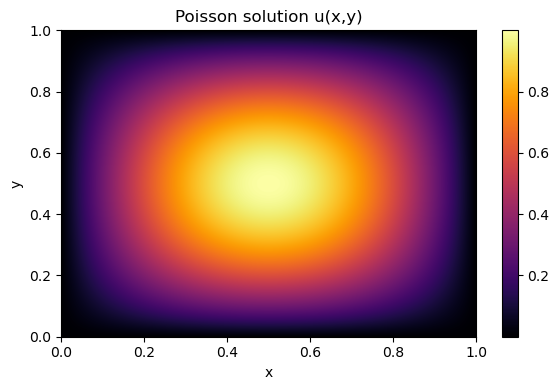

In [34]:
"""
Scientific Computing for All — Stage 1 (GPU Core)
=================================================
A modular, GPU-accelerated mini-framework for 2D PDEs.

Stage 1 includes:
- Dirichlet, Neumann, and Robin boundary conditions (per side)
- Matrix-free GPU operators (5-point Laplacian) with CuPy RawKernels
  (auto-enabled for homogeneous Dirichlet; vectorized path otherwise)
- Equations: Poisson (steady), Diffusion (transient), Wave (leapfrog)
- CPU fallback (NumPy) so it runs anywhere
- Interactive menu runner

This version patches the operator to be strictly LINEAR.
All boundary constants (β) are added to RHS / sources, not inside A@u.
"""
from __future__ import annotations
import os, time
from dataclasses import dataclass

# ------------------------------
# Backend (CuPy if available)
# ------------------------------
use_cpu_fallback = bool(int(os.environ.get("CPU_FALLBACK", "0")))
try:
    import cupy as cp
    import cupyx.scipy.sparse.linalg as cxl
    xp = cp
    gpu = (not use_cpu_fallback)
except Exception:
    import numpy as xp
    cp = None
    cxl = None
    gpu = False

# ------------------------------
# Core data structures
# ------------------------------
@dataclass
class Grid2D:
    Nx: int
    Ny: int
    Lx: float = 1.0
    Ly: float = 1.0

    @property
    def hx(self) -> float:
        return self.Lx/(self.Nx+1)

    @property
    def hy(self) -> float:
        return self.Ly/(self.Ny+1)

    @property
    def shape(self):
        return (self.Ny, self.Nx)

@dataclass
class Boundary:
    # Each side is a tuple: ("Dirichlet", phi) OR ("Neumann", q) OR ("Robin", (a,b,c))
    left:   tuple[str, float | tuple] = ("Dirichlet", 0.0)
    right:  tuple[str, float | tuple] = ("Dirichlet", 0.0)
    bottom: tuple[str, float | tuple] = ("Dirichlet", 0.0)
    top:    tuple[str, float | tuple] = ("Dirichlet", 0.0)

# ------------------------------
# Utility helpers
# ------------------------------
def arr_like(grid: Grid2D, dtype):
    return xp.zeros(grid.shape, dtype=dtype)

def to_backend(a):
    if gpu and not isinstance(a, xp.ndarray):
        return xp.asarray(a)
    return a

def _is_homog_dirichlet(bc: Boundary) -> bool:
    def side_ok(side):
        kind, val = side
        return (kind.lower() == "dirichlet") and (float(val) == 0.0)
    return side_ok(bc.left) and side_ok(bc.right) and side_ok(bc.bottom) and side_ok(bc.top)

def _alpha_beta(side, h):
    """Return (alpha, beta) such that u_ghost = alpha * u_edge + beta."""
    kind, val = side
    k = kind.lower()
    if k == "dirichlet":
        phi = float(val)
        return 0.0, float(phi)
    if k == "neumann":
        q = float(val)
        return 1.0, float(h*q)
    if k == "robin":
        a, b, c = val
        a = float(a); b = float(b); c = float(c)
        if abs(b) < 1e-30:
            # falls back to Dirichlet: a*u = c  -> u = c/a
            phi = c/a
            return 0.0, float(phi)
        alpha = 1.0 - (a*h)/b
        beta  = (h/b)*c
        return float(alpha), float(beta)
    raise ValueError(f"Unknown BC kind: {kind}")

def boundary_constant_vector(grid: Grid2D, bc: Boundary, dtype):
    """
    Build the additive RHS/source vector from the constant (beta) terms
    introduced by ghost-node elimination at boundaries.

    NOTE: Our operator returns Y = 4u - u_left - u_right - u_up - u_down,
    which equals -(h^2 ∇² u). The solver multiplies by scale=1/h^2 to recover -∇² u.
    Here we build the constant vector in the SAME units as 'Y', i.e., it contributes
    exactly like those missing neighbors in the discrete stencil (before scaling).
    """
    Ny, Nx = grid.Ny, grid.Nx
    hx, hy = grid.hx, grid.hy
    v = xp.zeros((Ny, Nx), dtype=dtype)

    (_, bL) = _alpha_beta(bc.left,   hx)
    (_, bR) = _alpha_beta(bc.right,  hx)
    (_, bB) = _alpha_beta(bc.bottom, hy)
    (_, bT) = _alpha_beta(bc.top,    hy)

    # Missing neighbors are subtracted in Y, so constants appear as "+ beta" on RHS
    # (move them to the right-hand side).
    if bL != 0.0:
        v[:, 0]  += bL
    if bR != 0.0:
        v[:, -1] += bR
    if bB != 0.0:
        v[0, :]  += bB
    if bT != 0.0:
        v[-1, :] += bT

    return v.ravel()

# ------------------------------
# GPU RawKernel: 5-point Laplacian (float32) — homogeneous Dirichlet only
# ------------------------------
if gpu:
    _laplace5_src = r"""
    extern "C" __global__ void laplace5(
        const float* __restrict__ u,
        float* __restrict__ y,
        const int Nx, const int Ny)
    {
        int j = blockIdx.x * blockDim.x + threadIdx.x; // x (columns)
        int i = blockIdx.y * blockDim.y + threadIdx.y; // y (rows)
        if (i >= Ny || j >= Nx) return;
        int idx = i * Nx + j;
        float uc = u[idx];
        float left  = (j>0   ) ? u[idx-1]   : 0.0f;
        float right = (j+1<Nx) ? u[idx+1]   : 0.0f;
        float up    = (i>0   ) ? u[idx-Nx]  : 0.0f;
        float down  = (i+1<Ny) ? u[idx+Nx]  : 0.0f;
        // Returns 4u - neighbors = -(h^2 * Laplacian(u)) in discrete form (no scaling).
        y[idx] = 4.0f*uc - left - right - up - down;
    }
    """
    _laplace5 = cp.RawKernel(_laplace5_src, "laplace5")

# ------------------------------
# Operators (matrix-free, strictly linear)
# ------------------------------
class Laplace5:
    """
    Matrix-free 5-point Laplacian with general BC via ghost elimination.
    Acts on interior unknowns arranged as Ny×Nx.

    IMPORTANT: This operator is STRICTLY LINEAR. It applies ONLY the alpha*u_edge
    parts of ghost-node substitution inside A@u. All constant beta terms are excluded
    here and must be added to RHS/source via boundary_constant_vector() at solver level.

    Returns Y = (4u - neighbors - alpha*edge_corrections) which equals -(h^2 ∇² u) up to scaling.
    """
    def __init__(self, grid: Grid2D, bc: Boundary, dtype="float32", use_kernel=True):
        self.g = grid
        self.bc = bc
        self.dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64
        self.hx = grid.hx
        self.hy = grid.hy
        self.use_kernel = bool(use_kernel and gpu and self.dtype == xp.float32 and _is_homog_dirichlet(bc))
        if self.use_kernel:
            self.bx, self.by = 32, 8
            self.gx = (self.g.Nx + self.bx - 1)//self.bx
            self.gy = (self.g.Ny + self.by - 1)//self.by
        # Precompute (alpha, beta) per side (we will ONLY use alpha inside A, betas go to RHS)
        self.sides = {
            "left":   _alpha_beta(self.bc.left,   self.hx),
            "right":  _alpha_beta(self.bc.right,  self.hx),
            "bottom": _alpha_beta(self.bc.bottom, self.hy),
            "top":    _alpha_beta(self.bc.top,    self.hy),
        }

    def __matmul__(self, v: xp.ndarray) -> xp.ndarray:
        Ny, Nx = self.g.Ny, self.g.Nx
        u = v.reshape(Ny, Nx)
        y = xp.empty_like(u)
        if self.use_kernel:
            _laplace5((self.gx, self.gy), (self.bx, self.by),
                      (u.ravel(), y.ravel(), xp.int32(Nx), xp.int32(Ny)))
            return y.ravel()

        # Vectorized linear path (CPU or GPU) with BC alphas only (NO betas)
        y[:] = 4.0 * u
        # interior neighbors
        y[1:,   :] -= u[:-1,  :]  # up
        y[:-1,  :] -= u[1:,   :]  # down
        y[:, 1: ] -= u[:, :-1]    # left
        y[:, :-1] -= u[:, 1: ]    # right

        # --- linear BC corrections via u_ghost = alpha*u_edge + beta   (use ONLY alpha part here)
        (aL, _bL) = self.sides["left"]
        (aR, _bR) = self.sides["right"]
        (aB, _bB) = self.sides["bottom"]
        (aT, _bT) = self.sides["top"]

        # left boundary affects column j=0 (missing left neighbor)
        if aL != 0.0:
            y[:, 0]  -= (aL * u[:, 0])
        # right boundary affects column j=Nx-1 (missing right neighbor)
        if aR != 0.0:
            y[:, -1] -= (aR * u[:, -1])
        # bottom boundary affects row i=0 (missing up neighbor)
        if aB != 0.0:
            y[0, :]  -= (aB * u[0, :])
        # top boundary affects row i=Ny-1 (missing down neighbor)
        if aT != 0.0:
            y[-1, :] -= (aT * u[-1, :])

        return y.ravel()

# ------------------------------
# Poisson solver (CG)  -- uses RHS += scale * bc_const
# ------------------------------
class Poisson2D:
    def __init__(self, grid: Grid2D, bc: Boundary, dtype="float32"):
        self.g = grid
        self.bc = bc
        self.dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64
        self.A = Laplace5(grid, bc, dtype=dtype)
        # A returns Y = -(h^2 ∇² u); scale by 1/h^2 so scale*A = -∇²
        self.scale = 1.0/(self.g.hx*self.g.hx)  # assuming hx=hy

    def rhs(self, f_callable=None):
        Ny, Nx = self.g.Ny, self.g.Nx
        h = self.g.hx
        y = xp.arange(1, Ny+1, dtype=self.dtype)*h
        x = xp.arange(1, Nx+1, dtype=self.dtype)*h
        X, Y = xp.meshgrid(x, y, indexing="xy")
        if f_callable is None:
            # u = sin(pi x) sin(pi y) solves -∇² u = f
            F = 2*(xp.pi**2)*xp.sin(xp.pi*X)*xp.sin(xp.pi*Y)
        else:
            F = to_backend(f_callable(X, Y)).astype(self.dtype)
        return F  # (units of -∇² u)

    def solve_cg(self, b: xp.ndarray, tol=1e-8, maxiter=2000):
        # Add boundary constant vector on RHS (scaled to -∇² units)
        bc_const = boundary_constant_vector(self.g, self.bc, self.dtype)  # units of Y = -(h^2 ∇² u)
        b_eff = b.ravel() + self.scale * bc_const                         # convert to -∇² units

        n = self.g.Nx*self.g.Ny
        if gpu and cxl is not None:
            Aop = cxl.LinearOperator((n, n), matvec=lambda v: self.scale*(self.A@v), dtype=self.dtype)
            Minv = cxl.LinearOperator((n, n), matvec=lambda v: 0.25*v, dtype=self.dtype)
            u, info = cxl.cg(Aop, b_eff, tol=tol, maxiter=maxiter, M=Minv)
            return u.reshape(self.g.shape), info

        # CPU fallback (simple CG)
        u = xp.zeros(n, dtype=self.dtype)
        r = b_eff - self.scale*(self.A@u)
        z = 0.25*r
        p = z.copy()
        rz = float(xp.dot(r, z))
        r0 = float(xp.linalg.norm(r))
        for _ in range(1, maxiter+1):
            Ap = self.scale*(self.A@p)
            alpha = rz/float(xp.dot(p, Ap))
            u += alpha*p
            r -= alpha*Ap
            if float(xp.linalg.norm(r)) <= tol*(r0 if r0>0 else 1.0):
                break
            z = 0.25*r
            rz_new = float(xp.dot(r, z))
            beta = rz_new/rz
            p = z + beta*p
            rz = rz_new
        return u.reshape(self.g.shape), 0

# ------------------------------
# Diffusion solver (explicit Euler, CFL-safe)
# source includes + alpha * lap(u) + (scale * bc_const) term each step
# ------------------------------
class Diffusion2D:
    def __init__(self, grid: Grid2D, bc: Boundary, alpha=1.0, dtype="float32"):
        self.g = grid
        self.bc = bc
        self.alpha = float(alpha)
        self.dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64
        self.A = Laplace5(grid, bc, dtype=dtype)
        self.h = grid.hx  # assume hx=hy
        # stability for explicit Euler (2D 5-pt): dt <= h^2/(4*alpha)
        self.dt_stable = (self.h*self.h)/(4.0*self.alpha)
        # Precompute RHS constant source from boundaries, in ∇² units
        self.bc_src = (1.0/(self.h*self.h)) * boundary_constant_vector(self.g, self.bc, self.dtype)

    def step_explicit(self, u: xp.ndarray, dt: float, source: xp.ndarray|None=None) -> xp.ndarray:
        assert dt <= self.dt_stable + 1e-12, "dt too large for explicit Euler (reduce dt or use implicit scheme)"
        Au = self.A @ u.ravel()          # Y = -(h^2 ∇² u)
        lap_u = (-Au)/(self.h*self.h)    # ∇² u
        rhs = self.alpha * lap_u + self.bc_src
        if source is not None:
            rhs = rhs + source.ravel()
        return u + dt * rhs.reshape(self.g.shape)

# ------------------------------
# Wave equation (leapfrog)
# u_tt = c^2 ∇² u + s
# Add c^2 * dt^2 * bc_src each step (bc_src is ∇²-units)
# ------------------------------
class Wave2D:
    def __init__(self, grid: Grid2D, bc: Boundary, c=1.0, dtype="float32"):
        self.g = grid
        self.bc = bc
        self.c = float(c)
        self.dtype = xp.float32 if str(dtype).startswith("float32") else xp.float64
        self.A = Laplace5(grid, bc, dtype=dtype)
        self.h = grid.hx
        self.dt_cfl = self.h/(self.c*(2.0**0.5))
        # Precompute boundary source in ∇² units
        self.bc_src = (1.0/(self.h*self.h)) * boundary_constant_vector(self.g, self.bc, self.dtype)

    def lap(self, u):
        Au = self.A @ u.ravel()      # Y = -(h^2 ∇² u)
        return (-Au)/(self.h*self.h) # ∇² u

    def step_leapfrog(self, u_curr: xp.ndarray, u_prev: xp.ndarray, dt: float, source: xp.ndarray|None=None):
        assert dt <= self.dt_cfl + 1e-12, "dt too large for leapfrog (CFL violated)"
        lap_u = self.lap(u_curr)
        extra = self.bc_src
        if source is not None:
            extra = extra + source.ravel()
        return 2*u_curr - u_prev + (self.c**2)*(dt*dt)*lap_u.reshape(self.g.shape) + (dt*dt)*extra.reshape(self.g.shape)

# ------------------------------
# Interactive Stage-1 Runner (menu-driven)
# ------------------------------
def _prompt_choice(title, options, default_idx=0):
    print(f"\n{title}")
    for i, opt in enumerate(options, 1):
        print(f"  {i}) {opt}")
    raw = input(f"Choose [1-{len(options)}] (default {default_idx+1}): ").strip()
    if not raw:
        return default_idx
    try:
        k = int(raw) - 1
        if 0 <= k < len(options):
            return k
    except Exception:
        pass
    print("Invalid choice; using default.")
    return default_idx

def _prompt_int(msg, default):
    raw = input(f"{msg} [default {default}]: ").strip()
    if not raw:
        return default
    try:
        v = int(raw)
        return v
    except Exception:
        print("Invalid int; using default.")
        return default

def _prompt_float(msg, default):
    raw = input(f"{msg} [default {default}]: ").strip()
    if not raw:
        return default
    try:
        v = float(raw)
        return v
    except Exception:
        print("Invalid number; using default.")
        return default

def _prompt_bc(side_name):
    kind_idx = _prompt_choice(
        f"{side_name} boundary type",
        ["Dirichlet", "Neumann", "Robin"],
        0,
    )
    if kind_idx == 0:
        val = _prompt_float(f"{side_name} Dirichlet value φ", 0.0)
        return ("Dirichlet", val)
    elif kind_idx == 1:
        val = _prompt_float(f"{side_name} Neumann flux q (∂u/∂n)", 0.0)
        return ("Neumann", val)
    else:
        a = _prompt_float(f"{side_name} Robin 'a'", 1.0)
        b = _prompt_float(f"{side_name} Robin 'b' (≠0)", 1.0)
        c = _prompt_float(f"{side_name} Robin 'c'", 0.0)
        return ("Robin", (a, b, c))

def run_interactive():
    print("\n=== Scientific Computing for All — Stage 1 ===")
    print("GPU backend:", "available" if gpu else "CPU fallback")
    if gpu:
        print("(Tip: set CPU_FALLBACK=1 to force CPU mode)")

    Nx = _prompt_int("Grid Nx (columns)", 256)
    Ny = _prompt_int("Grid Ny (rows)", 256)
    dtype_idx = _prompt_choice(
        "Numeric precision",
        ["float32 (faster)", "float64 (more precise)"],
        0,
    )
    dtype = "float32" if dtype_idx == 0 else "float64"

    eq_idx = _prompt_choice(
        "Which equation?",
        ["Poisson (steady)", "Diffusion (transient)", "Wave (leapfrog)"],
        0,
    )

    print("\n-- Boundary conditions (each side can be different) --")
    left  = _prompt_bc("Left")
    right = _prompt_bc("Right")
    bottom= _prompt_bc("Bottom")
    top   = _prompt_bc("Top")
    bc = Boundary(left=left, right=right, bottom=bottom, top=top)

    g = Grid2D(Nx=Nx, Ny=Ny, Lx=1.0, Ly=1.0)

    try:
        import matplotlib.pyplot as plt
        HAVE_PLOT = True
    except Exception:
        HAVE_PLOT = False

    if eq_idx == 0:
        # --- Poisson ---
        tol = _prompt_float("CG tolerance (smaller is stricter)", 1e-6)
        maxiter = _prompt_int("CG max iterations", 2000)

        poisson = Poisson2D(g, bc, dtype=dtype)
        b = poisson.rhs()  # analytic RHS for sin-sin solution

        t0 = time.perf_counter()
        u, info = poisson.solve_cg(b, tol=tol, maxiter=maxiter)
        if gpu:
            xp.cuda.Stream.null.synchronize()
        t1 = time.perf_counter()

        # If BCs are homogeneous Dirichlet (β=0), we can compare to exact
        if _is_homog_dirichlet(bc):
            h = g.hx
            y = xp.arange(1, g.Ny + 1, dtype=u.dtype) * h
            x = xp.arange(1, g.Nx + 1, dtype=u.dtype) * h
            X, Y = xp.meshgrid(x, y, indexing="xy")
            u_exact = xp.sin(xp.pi * X) * xp.sin(xp.pi * Y)
            rel_err = float(xp.linalg.norm(u - u_exact) / xp.linalg.norm(u_exact))
            err_msg = f"relative L2 error vs exact: {rel_err:.3e}"
        else:
            err_msg = "(no exact comparison for these BCs)"

        print("\nPoisson results:")
        print(f"  time: {t1 - t0:.3f} s  | backend: {'GPU' if gpu else 'CPU'} | info: {info}")
        print(" ", err_msg)

        if HAVE_PLOT:
            plt.figure(figsize=(6, 4))
            plt.imshow((u if not gpu else cp.asnumpy(u)), origin="lower",
                       cmap="inferno", aspect="auto", extent=[0, g.Lx, 0, g.Ly])
            plt.colorbar()
            plt.title("Poisson solution u(x,y)")
            plt.xlabel("x"); plt.ylabel("y")
            plt.tight_layout(); plt.show()
        else:
            print("(matplotlib not available; skipping plot)")

    elif eq_idx == 1:
        # --- Diffusion ---
        alpha = _prompt_float("Diffusivity alpha", 1.0)
        steps = _prompt_int("Number of time steps", 400)
        safety = _prompt_float("CFL fraction (<=1.0)", 0.9)

        diff = Diffusion2D(g, bc, alpha=alpha, dtype=dtype)
        u = arr_like(g, dtype=xp.float32 if dtype == "float32" else xp.float64)

        r = max(2, min(g.Nx, g.Ny) // 50)
        u[g.Ny // 2 - r : g.Ny // 2 + r, g.Nx // 2 - r : g.Nx // 2 + r] = 1.0
        dt = safety * diff.dt_stable

        print(f"Using dt={dt:.3e} (stable <= {diff.dt_stable:.3e})")

        t0 = time.perf_counter()
        for _ in range(1, steps + 1):
            u = diff.step_explicit(u, dt)
        if gpu:
            xp.cuda.Stream.null.synchronize()
        t1 = time.perf_counter()

        print("\nDiffusion results:")
        print(f"  steps: {steps} | dt: {dt:.3e} | time: {t1 - t0:.3f} s  | backend: {'GPU' if gpu else 'CPU'}")

        if HAVE_PLOT:
            plt.figure(figsize=(6, 4))
            plt.imshow((u if not gpu else cp.asnumpy(u)),
                       origin="lower", cmap="viridis", aspect="auto",
                       extent=[0, g.Lx, 0, g.Ly])
            plt.colorbar()
            plt.title("Diffusion: u(x,y) at final time")
            plt.xlabel("x"); plt.ylabel("y")
            plt.tight_layout(); plt.show()
        else:
            print("(matplotlib not available; skipping plot)")

    else:
        # --- Wave equation (leapfrog) ---
        c_speed = _prompt_float("Wave speed c", 1.0)
        steps = _prompt_int("Number of time steps", 600)
        safety = _prompt_float("CFL fraction (<=1.0)", 0.9)

        wave = Wave2D(g, bc, c=c_speed, dtype=dtype)

        # Initial condition: Gaussian bump at center, zero initial velocity
        h = g.hx
        y = xp.arange(1, g.Ny + 1, dtype=xp.float32 if dtype == "float32" else xp.float64) * h
        x = xp.arange(1, g.Nx + 1, dtype=xp.float32 if dtype == "float32" else xp.float64) * h
        X, Y = xp.meshgrid(x, y, indexing="xy")
        sigma = 0.10
        u0 = xp.exp(-((X - 0.5) ** 2 + (Y - 0.5) ** 2) / (2 * sigma ** 2))

        dt = safety * wave.dt_cfl
        print(f"Using dt={dt:.3e} (CFL <= {wave.dt_cfl:.3e})")

        # Start-up step for leapfrog (zero initial velocity):
        # u_{-1} = u_0 + 0.5 * c^2 * dt^2 * ∇² u_0
        lap_u0 = wave.lap(u0)
        u_prev = u0 + 0.5 * (c_speed ** 2) * (dt ** 2) * lap_u0
        u_curr = u0.copy()

        t0 = time.perf_counter()
        for _ in range(steps):
            u_next = wave.step_leapfrog(u_curr, u_prev, dt)
            u_prev, u_curr = u_curr, u_next
        if gpu:
            xp.cuda.Stream.null.synchronize()
        t1 = time.perf_counter()

        print("\nWave equation results:")
        print(f"  steps: {steps} | dt: {dt:.3e} | time: {t1 - t0:.3f} s  | backend: {'GPU' if gpu else 'CPU'}")

        if HAVE_PLOT:
            plt.figure(figsize=(6, 4))
            plt.imshow((u_curr if not gpu else cp.asnumpy(u_curr)),
                       origin="lower", cmap="plasma", aspect="auto",
                       extent=[0, g.Lx, 0, g.Ly])
            plt.colorbar()
            plt.title("Wave: u(x,y) at final time")
            plt.xlabel("x"); plt.ylabel("y")
            plt.tight_layout(); plt.show()
        else:
            print("(matplotlib not available; skipping plot)")

if __name__ == "__main__":
    run_interactive()
